# DL_1
`@Author: YUAN Yanzhe`  
The 5th iteration    
use nn model (simple dense layers) refered to `Baseline_2nd`, still got work to do (modify the network to more complex ones)

Output: ashrae_nn_1.csv

Scores: 3.249

In [2]:
import os
import kaggle
from zipfile import ZipFile
# import psycopg2
# from sqlalchemy import create_engine
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn import linear_model
from pandas.plotting import scatter_matrix
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
from wordcloud import WordCloud

Using TensorFlow backend.


## Load Data

In [5]:
df_building_metadata = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
print(df_building_metadata)
df_building_metadata.info()
df_building_metadata.describe()

      site_id  building_id                    primary_use  square_feet  \
0           0            0                      Education         7432   
1           0            1                      Education         2720   
2           0            2                      Education         5376   
3           0            3                      Education        23685   
4           0            4                      Education       116607   
...       ...          ...                            ...          ...   
1444       15         1444  Entertainment/public assembly        19619   
1445       15         1445                      Education         4298   
1446       15         1446  Entertainment/public assembly        11265   
1447       15         1447            Lodging/residential        29775   
1448       15         1448                         Office        92271   

      year_built  floor_count  
0         2008.0          NaN  
1         2004.0          NaN  
2         1991.

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [6]:
df_train = pd.read_csv('ashrae-energy-prediction/train.csv')
print(df_train)
df_train.info()
df_train.describe()

          building_id  meter            timestamp  meter_reading
0                   0      0  2016-01-01 00:00:00          0.000
1                   1      0  2016-01-01 00:00:00          0.000
2                   2      0  2016-01-01 00:00:00          0.000
3                   3      0  2016-01-01 00:00:00          0.000
4                   4      0  2016-01-01 00:00:00          0.000
...               ...    ...                  ...            ...
20216095         1444      0  2016-12-31 23:00:00          8.750
20216096         1445      0  2016-12-31 23:00:00          4.825
20216097         1446      0  2016-12-31 23:00:00          0.000
20216098         1447      0  2016-12-31 23:00:00        159.575
20216099         1448      0  2016-12-31 23:00:00          2.850

[20216100 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_r

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [7]:
df_test = pd.read_csv('ashrae-energy-prediction/test.csv')
print(df_test)
df_test.info()
df_test.describe()

            row_id  building_id  meter            timestamp
0                0            0      0  2017-01-01 00:00:00
1                1            1      0  2017-01-01 00:00:00
2                2            2      0  2017-01-01 00:00:00
3                3            3      0  2017-01-01 00:00:00
4                4            4      0  2017-01-01 00:00:00
...            ...          ...    ...                  ...
41697595  41697595         1444      0  2018-05-09 07:00:00
41697596  41697596         1445      0  2018-05-09 07:00:00
41697597  41697597         1446      0  2018-05-09 07:00:00
41697598  41697598         1447      0  2018-05-09 07:00:00
41697599  41697599         1448      0  2018-05-09 07:00:00

[41697600 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB


,row_id,building_id,meter
count,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01
std,1.203706e+07,4.297680e+02,9.278067e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00
50%,2.084880e+07,9.000000e+02,0.000000e+00
75%,3.127320e+07,1.194250e+03,1.000000e+00
max,4.169760e+07,1.448000e+03,3.000000e+00


In [8]:
df_weather_train = pd.read_csv('ashrae-energy-prediction/weather_train.csv')
print(df_weather_train)
df_weather_train.info()
df_weather_train.describe()

        site_id            timestamp  air_temperature  cloud_coverage  \
0             0  2016-01-01 00:00:00             25.0             6.0   
1             0  2016-01-01 01:00:00             24.4             NaN   
2             0  2016-01-01 02:00:00             22.8             2.0   
3             0  2016-01-01 03:00:00             21.1             2.0   
4             0  2016-01-01 04:00:00             20.0             2.0   
...         ...                  ...              ...             ...   
139768       15  2016-12-31 19:00:00              3.0             NaN   
139769       15  2016-12-31 20:00:00              2.8             2.0   
139770       15  2016-12-31 21:00:00              2.8             NaN   
139771       15  2016-12-31 22:00:00              2.2             NaN   
139772       15  2016-12-31 23:00:00              1.7             NaN   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0                  20.0                NaN              1

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [9]:
df_weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
print(df_weather_test)
df_weather_test.info()
df_weather_test.describe()

        site_id            timestamp  air_temperature  cloud_coverage  \
0             0  2017-01-01 00:00:00             17.8             4.0   
1             0  2017-01-01 01:00:00             17.8             2.0   
2             0  2017-01-01 02:00:00             16.1             0.0   
3             0  2017-01-01 03:00:00             17.2             0.0   
4             0  2017-01-01 04:00:00             16.7             2.0   
...         ...                  ...              ...             ...   
277238       15  2018-12-31 19:00:00              3.3             NaN   
277239       15  2018-12-31 20:00:00              2.8             NaN   
277240       15  2018-12-31 21:00:00              2.8             NaN   
277241       15  2018-12-31 22:00:00              2.8             NaN   
277242       15  2018-12-31 23:00:00              3.3             NaN   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0                  11.7                NaN              1

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,277243.000000,277139.000000,136795.000000,276916.000000,181655.000000,255978.000000,264873.000000,276783.000000
mean,7.484654,14.276863,2.187317,7.487658,1.095395,1016.195762,180.426023,3.548873
std,4.616959,10.741605,2.620627,10.153973,9.163511,7.940392,110.456872,2.317184
min,0.000000,-28.100000,0.000000,-31.600000,-1.000000,972.000000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.600000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.400000,0.000000,1016.300000,190.000000,3.100000
75%,12.000000,22.200000,4.000000,15.000000,0.000000,1020.800000,280.000000,4.600000
max,15.000000,48.300000,9.000000,26.700000,597.000000,1050.100000,360.000000,24.200000


## Data Preprocessing

In [10]:
# reduce memory use
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
df_building_metadata = reduce_mem_usage(df_building_metadata)
df_weather_train = reduce_mem_usage(df_weather_train)

df_train = reduce_mem_usage(df_train)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [12]:
df_weather_train['timestamp']=pd.to_datetime(df_weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_train['timestamp']=pd.to_datetime(df_train["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [13]:
df_weather_train['date'] = pd.to_datetime(df_weather_train["timestamp"]).dt.strftime('%d/%m/%Y')
df_weather_train.groupby(['date']).air_temperature.min()

date
01/01/2016   -16.703125
01/02/2016    -5.000000
01/03/2016   -17.093750
01/04/2016     0.600098
01/05/2016     2.000000
                ...    
31/05/2016     6.000000
31/07/2016     9.703125
31/08/2016    11.398438
31/10/2016    -0.500000
31/12/2016   -17.703125
Name: air_temperature, Length: 366, dtype: float16

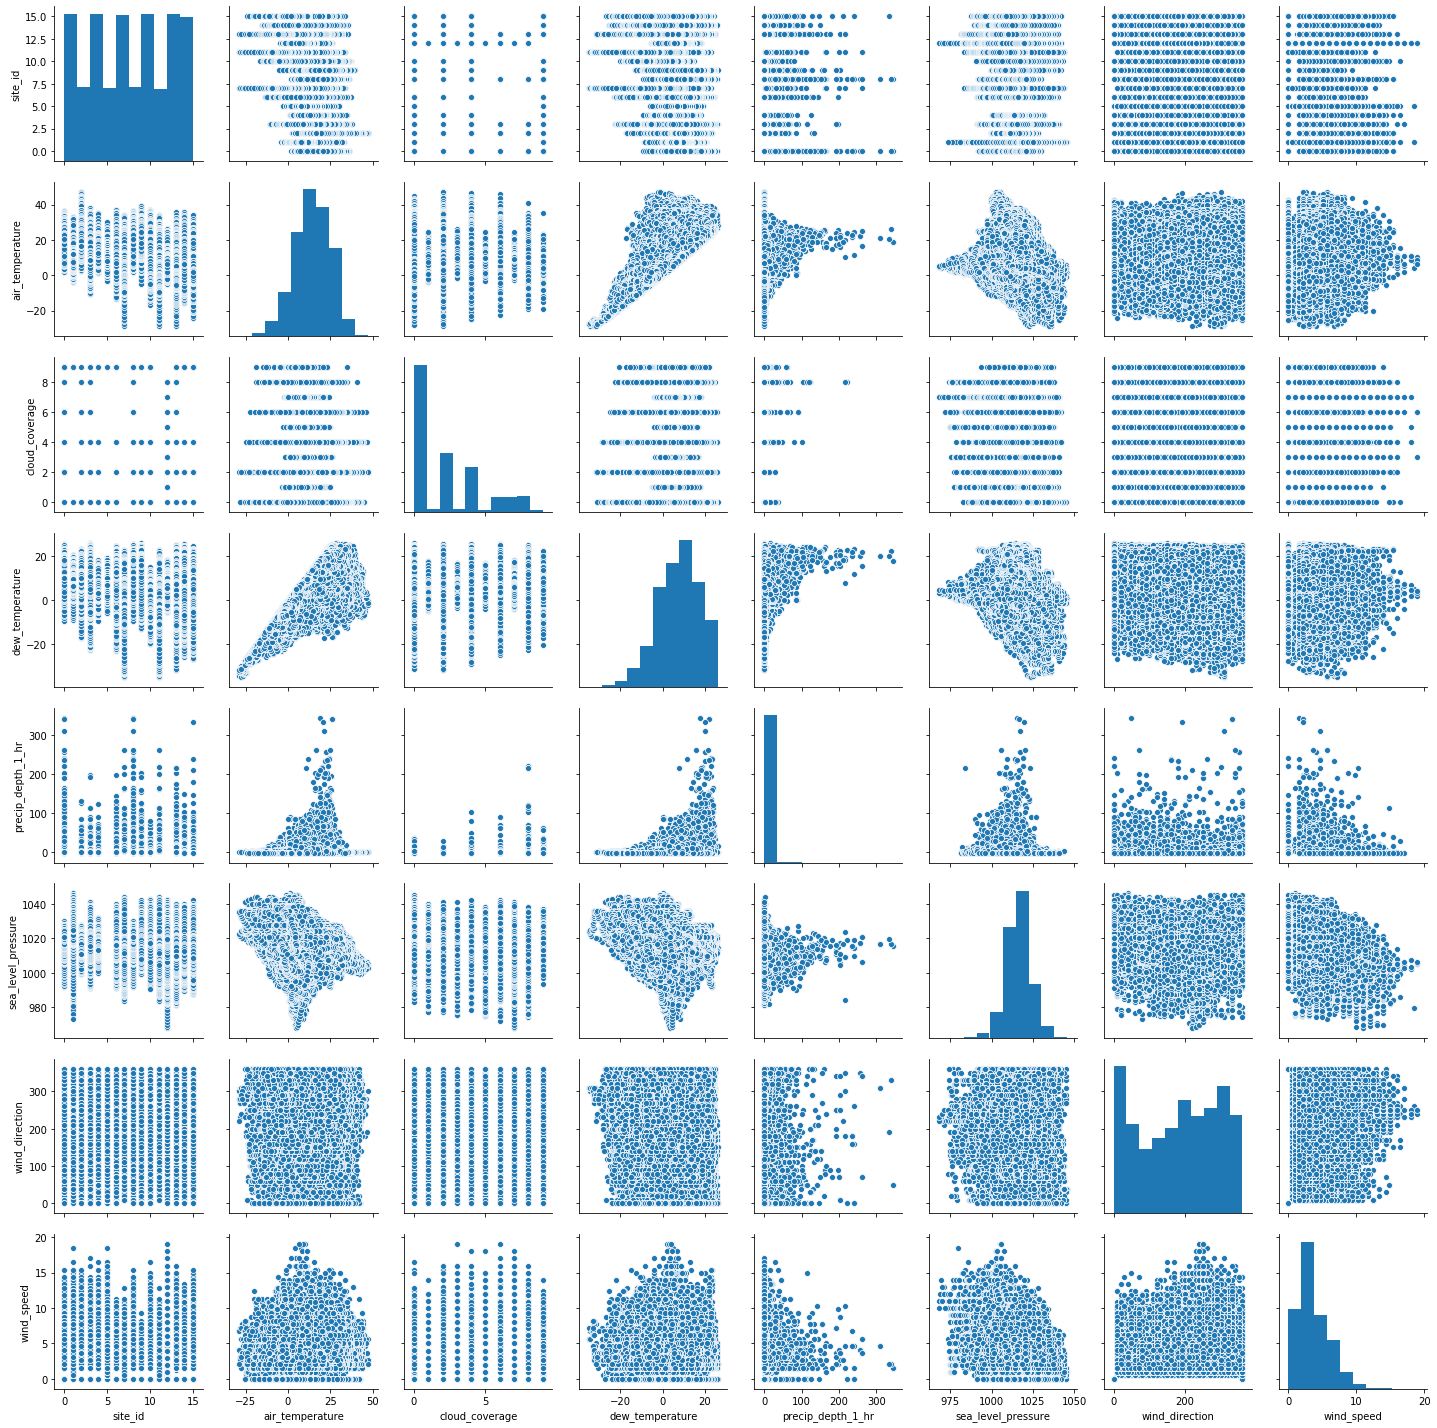

In [14]:
# A little visualization, we can see that 
sns.pairplot(df_weather_train) 

- there are very few linear relationships between pairs of weather variables (with exception of air/dew temperature, which is expected). We'll have a look at correlations with other variables after merging the dataset

In [15]:
# The new df_train is a integrated one
df_train = df_train.merge(df_building_metadata, on='building_id', how='left')
df_train = df_train.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')

In [16]:
df_train.info()
print (df_train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 17 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
date                  object
dtypes: datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2), object(2)
memory usage: 1.2+ GB
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count         

In [17]:
df_train.groupby(['meter']).meter.count()

meter
0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

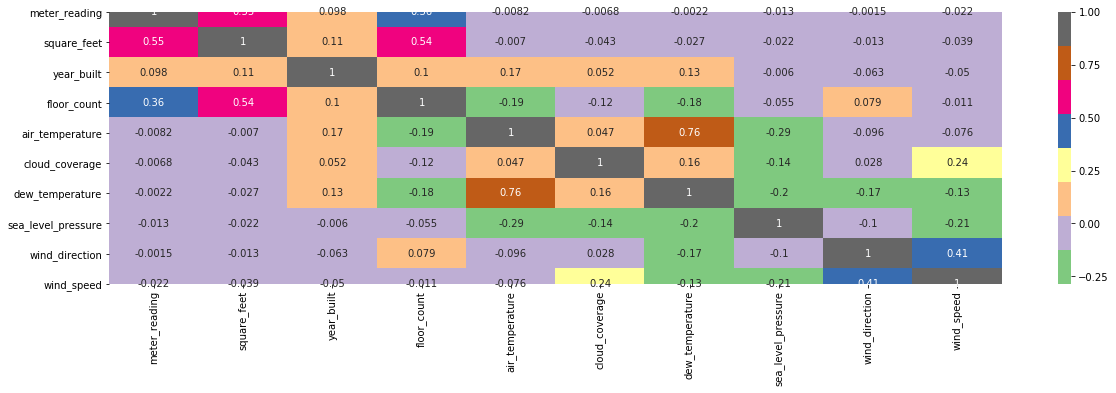

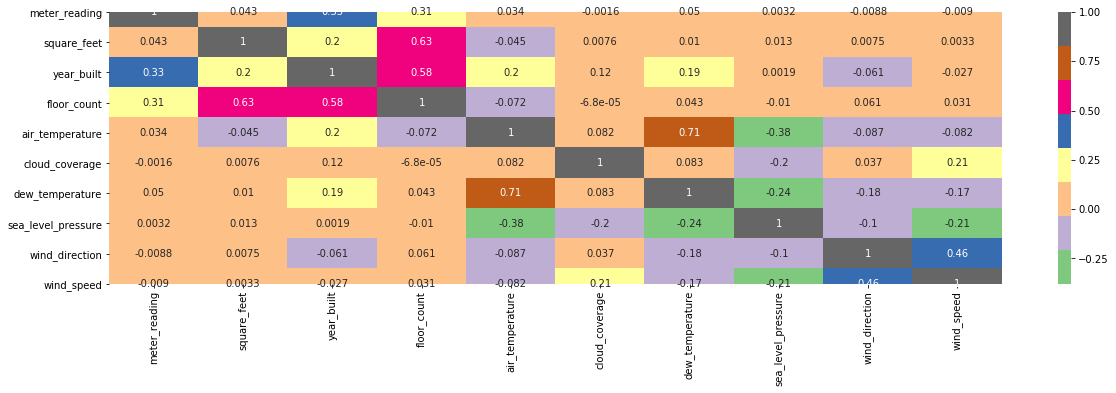

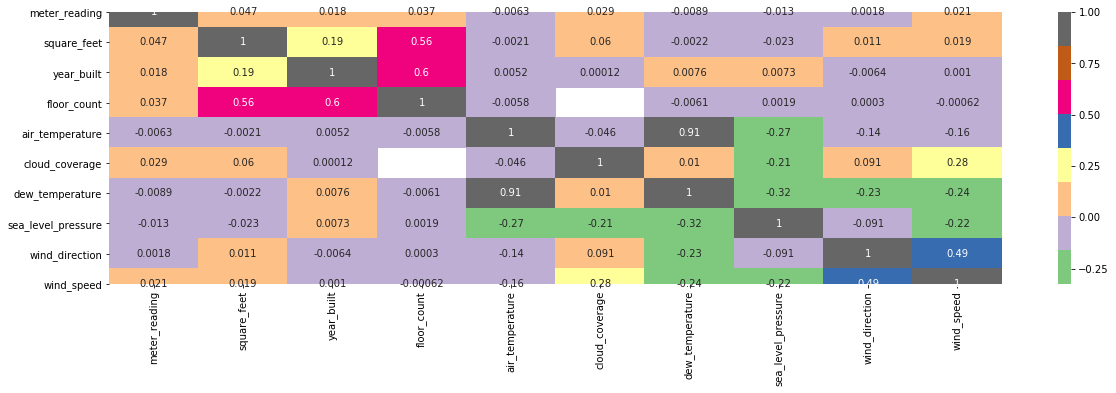

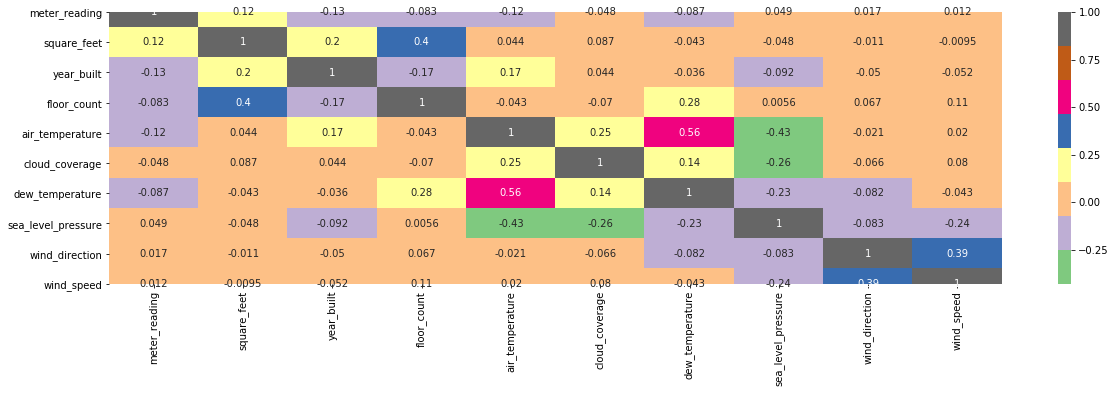

In [18]:
# A little feature correlation map visualization
for m in range(0,4):
    matrix = df_train[df_train.meter == m][['meter_reading','square_feet','year_built','floor_count',
             'air_temperature','cloud_coverage','dew_temperature','sea_level_pressure','wind_direction','wind_speed']].corr()
    f, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(matrix,annot=True,cmap="Accent")

- we can see that certain independent variables have relatively strong correlation with meters' readings (e.g. square_feet and floor count on electricity meter) while others are mostly correlated with other independent variables
-  Since dropping NaN values from df with df_train.dropna() will leave us with only building_id, meter, timestamp and meter_reading. We need to fill in the gaps some other way

## Model-Training

In [19]:
x_train = df_train[['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature','sea_level_pressure','wind_direction','wind_speed']]
y_train = df_train['meter_reading']
x_train = x_train.fillna(0) 
y_train = y_train.fillna(0)

In [20]:
# Model
model = Sequential()
model.add(Dense(8, input_dim=9, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

- to minimise the time spent training the dataset I set the number of epochs to only 1 (increasing epoch size to 3 only increases rsq by 10% of original value) we can utilise batch_size in case of memory issues

In [21]:
# Hypoparameters
nepoch = 3
nbatch = 16
model.fit(x_train, y_train, epochs=nepoch) #, batch_size=nbatch

Epoch 1/3
20216100/20216100 [==============================] - 1504s 74us/step - loss: 23465850617.7090 - mse: 23446497280.0000
Epoch 2/3
20216100/20216100 [==============================] - 1543s 76us/step - loss: 23461512593.4476 - mse: 23440764928.0000
Epoch 3/3
20216100/20216100 [==============================] - 1480s 73us/step - loss: 23460581822.5646 - mse: 23439216640.0000


In [22]:
y_train_learn = model.predict(x_train)
y_train_learn = pd.DataFrame(y_train_learn, columns = ['meter_reading_pred'])
rsq = r2_score(y_train, y_train_learn)
print(rsq)

0.0007759931672163267


## Model Testing and Submissions

In [25]:
df_building_metadata = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
df_test = pd.read_csv('ashrae-energy-prediction/test.csv')
df_weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')

In [26]:
# Reduce the memory
df_test = reduce_mem_usage(df_test)
df_building_metadata = reduce_mem_usage(df_building_metadata)
df_weather_test = reduce_mem_usage(df_weather_test)

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [27]:
# Do the same data preprocessing as training data
df_weather_test['timestamp']=pd.to_datetime(df_weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_test['timestamp']=pd.to_datetime(df_test["timestamp"], format='%Y-%m-%d %H:%M:%S')


In [28]:
# Merge
df_test = df_test.merge(df_building_metadata, on='building_id', how='left')
df_test = df_test.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')

In [29]:
# The new df_test is an integrated one
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
row_id                int32
building_id           int16
meter                 int8
timestamp             datetime64[ns]
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), int16(1), int32(2), int8(2), object(1)
memory usage: 2.1+ GB


,row_id,building_id,meter,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,17099520.0,7253280.0,4.147570e+07,22155420.0,4.143680e+07,33896037.0,39180774.0,38718937.0,4.139551e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01,8.086134e+00,1.069469e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.203706e+07,4.297680e+02,9.278067e-01,5.134712e+00,1.160888e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.809375e+01,0.0,-3.159375e+01,-1.0,972.0,0.0,0.000000e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00,3.000000e+00,3.224350e+04,1951.0,1.0,7.800781e+00,0.0,0.000000e+00,0.0,1011.5,80.0,2.099609e+00
50%,2.084880e+07,9.000000e+02,0.000000e+00,9.000000e+00,7.226250e+04,1969.0,3.0,1.670312e+01,2.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00
75%,3.127320e+07,1.194250e+03,1.000000e+00,1.300000e+01,1.383875e+05,1993.0,6.0,2.390625e+01,4.0,1.670312e+01,0.0,1020.5,280.0,4.601562e+00
max,4.169760e+07,1.448000e+03,3.000000e+00,1.500000e+01,8.750000e+05,2017.0,26.0,4.831250e+01,9.0,2.670312e+01,597.0,1050.0,360.0,2.420312e+01


In [31]:
# Feature extracton and preprocessing:
x_test = df_test[['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature','sea_level_pressure','wind_direction','wind_speed']]
x_test = x_test.fillna(0) 

In [32]:
y_test = model.predict(x_test)

In [33]:
df_y_test = pd.DataFrame(y_test, columns=['meter_reading'])

In [34]:
df_y_test.insert(0, 'row_id', df_y_test.index)

In [35]:
print(df_y_test)
df_y_test.info()
df_y_test.describe()

            row_id  meter_reading
0                0     240.015808
1                1     240.015808
2                2     240.015808
3                3     240.015808
4                4     240.015808
...            ...            ...
41697595  41697595     240.015808
41697596  41697596     417.243500
41697597  41697597     240.015808
41697598  41697598     240.015808
41697599  41697599     240.015808

[41697600 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    float32
dtypes: float32(1), int64(1)
memory usage: 477.2 MB


,row_id,meter_reading
count,4.169760e+07,4.169760e+07
mean,2.084880e+07,3.172711e+03
std,1.203706e+07,7.474927e+03
min,0.000000e+00,8.827629e+01
25%,1.042440e+07,2.400158e+02
50%,2.084880e+07,2.400158e+02
75%,3.127320e+07,2.538690e+03
max,4.169760e+07,7.984387e+04


In [36]:
# Clean the 'outliers' (negative meter readings)
minVal = 0
df_y_test['meter_reading'].where(df_y_test['meter_reading'] >= minVal, minVal)

0           240.015808
1           240.015808
2           240.015808
3           240.015808
4           240.015808
               ...    
41697595    240.015808
41697596    417.243500
41697597    240.015808
41697598    240.015808
41697599    240.015808
Name: meter_reading, Length: 41697600, dtype: float32

In [37]:
# Make a submission file, the final output of x_test is df_y_test
df_y_test.to_csv('ashrae_nn_1.csv',index=False)

##### submission_nn_1 scores 3.249

## Model_2 Training

In [38]:
x_train = df_train[['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature','sea_level_pressure','wind_direction','wind_speed']]
y_train = df_train['meter_reading']
x_train = x_train.fillna(0) 
y_train = y_train.fillna(0)

In [48]:
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from keras.optimizers import RMSprop,Adam
import keras.backend as K

input_dim = 9
model_2 = Sequential()
# model_2.add(Embedding(input_length=input_dim))
# model_2.add(LSTM(units=8, activation = 'relu', input_shape=(1, input_dim)))
model_2.add(LSTM(units=64, activation = 'relu', input_shape = (20,input_dim)))
# model_2.add(Dense(128, activation='relu', input_dim=input_dim))
model_2.add(Dense(128, activation='relu'))
#model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(1, activation='relu'))
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
model_2.compile(optimizer = Adam(lr=1e-4),
              loss='mse',
              metrics=[rmse])

In [51]:
nepoch = 2
nbatch = 16
model_2.fit(x_train, y_train, batch_size=20, epochs=3) #, batch_size=nbatch

ValueError: Error when checking input: expected lstm_3_input to have 3 dimensions, but got array with shape (20216100, 9)